In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
assert tf.__version__.split(".")[0] == "2" # Designed for tensorflow >= 2.0.0

tf.compat.v1.random.set_random_seed(1234) # Setting a random seed so that results are reproducible

In [2]:
class linear_reg_model(tf.Module):
    def __init__(self,dims=1,initial_values=None):
        super().__init__()

        if not initial_values:
            self.m = tf.Variable(tf.random.uniform([dims]), name="gradient")
            self.c = tf.Variable(tf.random.uniform([dims]), name="intercept")
        else:
            self.m = tf.Variable([initial_values[0]], name="gradient")
            self.c = tf.Variable([initial_values[1]], name="intercept")

    def __call__(self,x):
        return (self.m*x) + self.c
    
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))

Using the general equation of a line as y = mx + c, we can describe any straight line in 2D using two values, m (the gradient of the line) and c (the intercept with the y axis). To make the model I initiate two variables, m and c. Tensorflow 2.0 deals with them as they are memebers of a tf.Module object. 

In the call method, the general equation is applied with the variables to produce the output.

The loss function is the mean square error of the predicited and true y values. This is a very standard loss function for regression tasks. 

In [3]:
def train(model, X_train, y_train, X_val=None, y_val=None, epochs=1, batch_size=1000, optimiser=tf.keras.optimizers.Adam(lr=0.1)):
    train_loss = tf.keras.metrics.Mean(name='train_loss') # Keeps track of the loss for us

    assert X_train.ndim == 1 and y_train.ndim == 1 # Make sure it is only a single dimension
    assert X_train.shape[0] == y_train.shape[0] # Make sure there are the same number of samples

    num_batches_train = X_train.shape[0]//batch_size + (1 if X_train.shape[0]%batch_size != 0 else 0)

    batched_train_data = np.array_split(np.stack([X_train,y_train]),num_batches_train,axis=1) # Split training data into batches
    
    if type(X_val) != type(None) and type(y_val) != type(None):
        assert X_val.ndim == 1 and y_val.ndim == 1 # Make sure it is only a single dimension
        assert X_val.shape[0] == y_val.shape[0] # Make sure there are the same number of samples
        
        num_batches_val = X_val.shape[0]//batch_size + (1 if X_val.shape[0]%batch_size != 0 else 0)

        batched_val_data = np.array_split(np.stack([X_val,y_val]),num_batches_val,axis=1)
        
        test_loss = tf.keras.metrics.Mean(name='test_loss') 
        
        template = "\rEpoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}" + " "*20
        
    else:
        batched_val_data = None
        
        template = "\rEpoch {}, Train Loss: {:.3f}" + " "*20
        
    for e in range(epochs):
        for X, y_true in batched_train_data:
            with tf.GradientTape() as tape: # Automatically watches the variables
                y_pred = model(X)
                loss = mse(y_true, y_pred)
            gradients = tape.gradient(loss, model.trainable_variables) 
            # Calculates the gradients of the loss with respect to each of the variables.
            optimiser.apply_gradients(zip(gradients, model.trainable_variables))
            # The optimser then uses the gradients to change the model variables to better reduce the loss.
            train_loss(loss)

        if batched_val_data: # If there is validation data then the val loss should be calculated.
            for X, y_true in batched_val_data:
                y_pred = model(X)
                loss = mse(y_true, y_pred)

                test_loss(loss)
                print(template.format(e+1, train_loss.result(), test_loss.result()),end="")
                
            test_loss.reset_states()
        else:
            print(template.format(e+1, train_loss.result()),end="")

        train_loss.reset_states()
        
        print()

The train method iterated over the dataset, calculating the loss at each step and then using the gradient of the loss with respect to each variable to change the values such that the loss decreases

In [4]:
def graph_model_dataset(model,X,y):
    plt.scatter(X,y,2,"b","x") # Shows the actual values in a scatter plot.
    plt.plot(X,model(X),"r") # Draws the model over the actual values. 
    plt.show()

In [5]:
def make_random_dataset(seed=0, min=0, max=100, samples=1000, scale=0.1, val_split=0.2):
    np.random.seed(seed)
    m, c = np.random.normal(size=2)

    train_steps, val_steps = int(samples * (1-val_split)), int(samples * val_split)

    x_train, x_val = np.linspace(min,max,train_steps), np.linspace(min,max,val_steps)

    func = np.vectorize(lambda x: (m*x) + c)
    y_train, y_val = func(x_train), func(x_val)

    x_train_noise, y_train_noise = np.random.normal(loc=0,scale=scale, size=(2,train_steps))
    x_val_noise, y_val_noise = np.random.normal(loc=0,scale=scale, size=(2,val_steps))

    x_train += x_train_noise
    x_val += x_val_noise
    y_train += y_train_noise
    y_val += y_val_noise
    
    target_val_loss = mse(y_val,func(x_val))
    print("Target val loss is {:.3f}, gradient is {:.3f}, intercept is {:.3f}".format(
        target_val_loss,
        m,
        c))

    return x_train, y_train, x_val, y_val

This method creates a random dataset with added noise, based on a seed so that the result is reproducible. It also calcuates the lowest possible loss a model could get when taking into account the noise, helping us know when the model is as good as it can be. 

First, trying it on the random dataset.

In [6]:
model = linear_reg_model()
X_train, y_train, X_val, y_val = make_random_dataset(seed=42,samples=10000,val_split=0.1,min=0,max=100,scale=2.5)

train(
    model,
    X_train, y_train,
    X_val, y_val,
    epochs=20, batch_size = 10000,
    optimiser=tf.keras.optimizers.Adam(lr=0.01))

Target val loss is 7.646, gradient is 0.497, intercept is -0.138
Epoch 1, Train Loss: 15.623, Val Loss: 12.351                    
Epoch 2, Train Loss: 12.689, Val Loss: 10.174                    
Epoch 3, Train Loss: 10.468, Val Loss: 8.699                    
Epoch 4, Train Loss: 8.951, Val Loss: 7.885                    
Epoch 5, Train Loss: 8.096, Val Loss: 7.639                    
Epoch 6, Train Loss: 7.815, Val Loss: 7.814                    
Epoch 7, Train Loss: 7.960, Val Loss: 8.217                    
Epoch 8, Train Loss: 8.338, Val Loss: 8.652                    
Epoch 9, Train Loss: 8.756, Val Loss: 8.971                    
Epoch 10, Train Loss: 9.064, Val Loss: 9.102                    
Epoch 11, Train Loss: 9.191, Val Loss: 9.043                    
Epoch 12, Train Loss: 9.134, Val Loss: 8.837                    
Epoch 13, Train Loss: 8.934, Val Loss: 8.547                    
Epoch 14, Train Loss: 8.654, Val Loss: 8.239                    
Epoch 15, Train Loss: 8.358, 

Training the model on the random test dataset. As there is a large sample size, few epochs (iterations over the dataset) are needed. The loss gets close to the calculated best loss. 

Model loss is 7.775, gradient is 0.497, intercept is 0.276


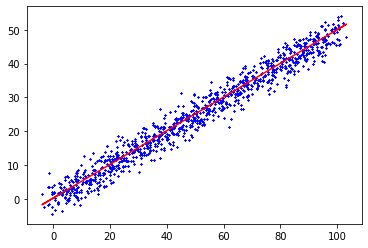

In [7]:
model_loss = mse(y_val, model(X_val))
print("Model loss is {:.3f}, gradient is {:.3f}, intercept is {:.3f}".format(
    model_loss,
    model.m.numpy()[0],
    model.c.numpy()[0]))
graph_model_dataset(model,X_val,y_val)

The gradient is exactly correct but the intercept is slightly off as it is relativly insignificant with the scale of the data. This could be improved by changing the random dataset to scale the intercept with the range.

In [8]:
def make_real_dataset(path="Salary_Data.csv"):
    with open(path,"r") as f:
        raw_data = f.read()
    data = np.array([i.split(",") for i in raw_data.split("\n")][1:-1],dtype=np.float32)
    return data[:,0], data[:,1]

This loads the real dataset from a CSV file and parses it. 

In [9]:
X_train, y_train = make_real_dataset()

We can calculate the best possible result using linear algebra as the dataset can easily fit in memory. This allows us to check if our model working properly. 

In [10]:
x = np.stack([X_train, np.ones_like(X_train)],axis=1)
x_t = np.transpose(x)
m, c = np.linalg.inv(x_t.dot(x)).dot(x_t).dot(y_train)
func = np.vectorize(lambda x: (m*x) + c)
target_loss = mse(y_train,func(X_train))
print("Target loss is {:.3f}, gradient is {:.3f}, intercept is {:.3f}".format(target_loss,m,c))

Target loss is 31270950.000, gradient is 9449.961, intercept is 25792.184


In [11]:
model = linear_reg_model()

train(
    model,
    X_train, y_train,
    epochs=500, batch_size = 30, optimiser=tf.keras.optimizers.Adam(lr=2e+3))

Epoch 1, Train Loss: 6502245888.000                    
Epoch 2, Train Loss: 4479334400.000                    
Epoch 3, Train Loss: 2851084544.000                    
Epoch 4, Train Loss: 1617277696.000                    
Epoch 5, Train Loss: 766386304.000                    
Epoch 6, Train Loss: 270666848.000                    
Epoch 7, Train Loss: 81663848.000                    
Epoch 8, Train Loss: 128693888.000                    
Epoch 9, Train Loss: 323898912.000                    
Epoch 10, Train Loss: 575283456.000                    
Epoch 11, Train Loss: 803778176.000                    
Epoch 12, Train Loss: 956466176.000                    
Epoch 13, Train Loss: 1010583424.000                    
Epoch 14, Train Loss: 969076352.000                    
Epoch 15, Train Loss: 852128128.000                    
Epoch 16, Train Loss: 688554048.000                    
Epoch 17, Train Loss: 508879264.000                    
Epoch 18, Train Loss: 340399552.000                  

Many more epochs are needed as there are few datapoints. Also, the learning rate for is very high. In a normal machine learning situation, this would probably be overfitting but since we know that the model should exactly fit the model it is fine.

Model loss is 31270956.000, gradient is 9449.963, intercept is 25792.197
Estimated salaray for experience of 6.5 years is £87216.95


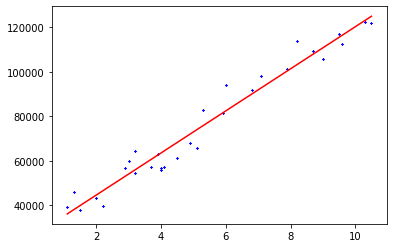

In [12]:
model_loss = mse(y_train, model(X_train))
print("Model loss is {:.3f}, gradient is {:.3f}, intercept is {:.3f}".format(
    model_loss,
    model.m.numpy()[0],
    model.c.numpy()[0]))
test_value = 6.5
pred_salary = model(test_value)
print("Estimated salaray for experience of {} years is £{:.2f}".format(test_value,pred_salary[0]))
graph_model_dataset(model,X_train,y_train)

The final loss is calculated along with the gradient and intercept of the model, all of which are very close to the values calculated earlier.